In [1]:
# （1）Setup
import numpy as np
import time
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers, backend
from keras.models import Model

#from convLSTM import CLSTM_cell as Recurrent_cell


In [2]:
# （2）Configure memory
gpus = tf.config.list_physical_devices(device_type='GPU')
# True: show the detailed CPU & GPU allocation information
tf.debugging.set_log_device_placement(False)
tf.config.set_soft_device_placement(False)
# only set the specified GPUs visible, otherwise the GPUs will assert different configurations for GPUs
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
# （3）Custom functions
# build x_train y_train x_val y_val    Mh-to-Nh
def BuildXY(data):
    n = data.shape[0]
    x = data[:n-1,...]
    y = data[1:,...]
    return x, y

# 自定义loss函数
def tf_ssim_loss(y_true,y_pred):
    total_loss=1-tf.image.ssim(y_true,y_pred,max_val=1)
    return total_loss   

# RMSE for calculating tensors
def rmse(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return backend.sqrt(backend.mean(tf.math.squared_difference(y_pred, y_true)))

# RMSE of array
def rmse1(x,y):
    rmse = np.sqrt(np.mean(np.square(y-x)))
    return rmse

In [4]:
#（4）Construct dataset
# Load data, convert the type to float32, and add a dimension
dataset = np.load('/home/tsj/BACKUP/HSM/dataset/nedata17-19-2h.npy')/1e10
dataset = np.expand_dims(dataset, axis=-1)
n=12
dataset = dataset.reshape(dataset.shape[0]//n,n,dataset.shape[1],dataset.shape[2],dataset.shape[3],dataset.shape[4])
print('dataset:The maxv is',np.max(dataset),',The minv is ',np.min(dataset))
print(dataset.shape)
print('Normal-dataset:The maxv is',np.max(dataset),',The minv is ',np.min(dataset))

dataset:The maxv is 225.56804 ,The minv is  2.3961146e-16
(1095, 12, 23, 37, 37, 1)
Normal-dataset:The maxv is 225.56804 ,The minv is  2.3961146e-16


In [5]:
# （5）Build x_train y_train x_val y_val
train_dataset = dataset[0:730, ...]
val_dataset = dataset[730:911, ...]   
test_dataset = dataset[911:, ...] 

# Apply the processing function to the datasets.m个（al,la,lo,1）预测n个（al,la,lo,1）
x_train, y_train = BuildXY(train_dataset)
x_val, y_val = BuildXY(val_dataset)
x_test, y_test = BuildXY(test_dataset)
# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))
print("Testing Dataset Shapes: " + str(x_test.shape) + ", " + str(y_test.shape))

Training Dataset Shapes: (729, 12, 23, 37, 37, 1), (729, 12, 23, 37, 37, 1)
Validation Dataset Shapes: (180, 12, 23, 37, 37, 1), (180, 12, 23, 37, 37, 1)
Testing Dataset Shapes: (183, 12, 23, 37, 37, 1), (183, 12, 23, 37, 37, 1)


In [7]:
'''
（6）Construct model
# Construct the input layer with no definite frame size.
Three ConvLSTM3D
Input shape: (samples, time, rows, cols, depth, channels)
Output shape: (samples, timesteps, new_rows, new_cols, new_depth, filters)(return_sequences=True时)
Output shape: (samples,new_rows,new_cols,new_depth,filters)(return_sequences=False时)
'''
inputs = layers.Input(shape=(x_train.shape[1:]))   # (None, 12, 23, 37, 37, 1  0)
print(inputs.shape)
n_filters = 16
kernelsize = 3

x = layers.ConvLSTM3D(filters=n_filters,kernel_size=kernelsize, padding="same",return_sequences=True,activation="relu")(inputs) #(None, 2, 23, 37, 37, 8)  7808
x = layers.ConvLSTM3D(filters=n_filters,kernel_size=kernelsize, dilation_rate=2, padding="same",return_sequences=True,activation="relu")(x) #(None, 2, 23, 37, 37, 8)  13856
x = layers.ConvLSTM3D(filters=n_filters,kernel_size=kernelsize, padding="same", return_sequences=True,activation="relu")(x) #(None, 2, 23, 37, 37, 8)  13856
#x = layers.BatchNormalization()(x)  #((None, 2, 23, 37, 37, 8)  32       
outputs = layers.Conv3D(filters=1, kernel_size=(1,1,1), activation="relu")(x)  #(None, 12, 23, 37, 37, 1)  9

# Next, we will build the complete model and compile it.
model = Model(inputs, outputs, name="DCNN-Ne17-19-24h")
model.summary()

(None, 12, 23, 37, 37, 1)
Model: "DCNN-Ne17-19-24h"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 23, 37, 37,   0         
                             1)]                                 
                                                                 
 conv_lstm3d (ConvLSTM3D)    (None, 12, 23, 37, 37, 1  29440     
                             6)                                  
                                                                 
 conv_lstm3d_1 (ConvLSTM3D)  (None, 12, 23, 37, 37, 1  55360     
                             6)                                  
                                                                 
 conv_lstm3d_2 (ConvLSTM3D)  (None, 12, 23, 37, 37, 1  55360     
                             6)                                  
                                                                 
 conv3d (Conv3D)        

In [8]:
# （7）Train model
model.compile(
    loss=rmse,
    optimizer=keras.optimizers.Adam(),
    metrics=["acc"],
)
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 100
batch_size =8

# Fit the model to the training data.
model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/100
92/92 [==============================] - 128s 1s/step - loss: 8.3593 - acc: 7.2609e-09 - val_loss: 3.2253 - val_acc: 0.0000e+00 - lr: 0.0010
Epoch 2/100
92/92 [==============================] - 116s 1s/step - loss: 2.5473 - acc: 3.6304e-09 - val_loss: 1.9356 - val_acc: 0.0000e+00 - lr: 0.0010
Epoch 3/100
92/92 [==============================] - 115s 1s/step - loss: 1.7719 - acc: 7.2609e-09 - val_loss: 1.3927 - val_acc: 0.0000e+00 - lr: 0.0010
Epoch 4/100
92/92 [==============================] - 115s 1s/step - loss: 1.4320 - acc: 7.2609e-09 - val_loss: 1.1796 - val_acc: 0.0000e+00 - lr: 0.0010
Epoch 5/100
92/92 [==============================] - 115s 1s/step - loss: 1.2768 - acc: 7.2609e-09 - val_loss: 1.0065 - val_acc: 0.0000e+00 - lr: 0.0010
Epoch 6/100
92/92 [==============================] - 115s 1s/step - loss: 1.1418 - acc: 7.2609e-09 - val_loss: 0.9690 - val_acc: 0.0000e+00 - lr: 0.0010
Epoch 7/100
92/92 [==============================] - 115s 1s/step - loss: 1.0923 -

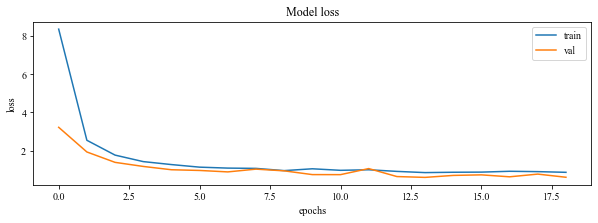

In [9]:
# （8）Visualize model performance
# Here the model loss for the training and the validation sets are plotted. 
fig = plt.subplots(figsize=(10, 3))
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_" + "loss"])
plt.title("Model {}".format("loss"))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

model.save('/home/tsj/BACKUP/HSM/1719dcnn/NeModel1719dcnn_24h.h5')
np.save('/home/tsj/BACKUP/HSM/1719dcnn//Metric1719dcnn_24h',model.history.history)


In [11]:
# (9) Predict and evaluate performance
T = dataset.shape[0]-1
RMSE = np.zeros(T*12,dtype='float32')
for i in range(T):    
    test = np.expand_dims(dataset[i], axis=0)  #(1,92,37,37,1)
    Pre_nemaps = model.predict(test)
  
    Ori_nemaps = np.squeeze(dataset[i+1]).reshape(12, 23, 37, 37)
    Pre_nemaps = np.squeeze(Pre_nemaps).reshape(12, 23, 37, 37)
    for h in range(12):
        RMSE[i*12+h] = rmse1(Pre_nemaps[h] , Ori_nemaps[h])     #计算每个时间的rmse
np.save("/home/tsj/BACKUP/HSM/1719dcnn//RMSE1719-24h.npy",RMSE)


1/1 [==============================] - 0s 55ms/step
